In [1]:
# ==============================================================================
# Cell 1: Introduction, Setup, and Configuration (Updated)
# ==============================================================================
#
# NEW FEATURES in this version:
# - Stochastic Weight Averaging (SWA) for the Generator to find a better,
#   more stable minimum in the loss landscape.
# - Detailed, normalized Fréchet Distance reporting, split by feature type.
# - A more robust implementation of the mode-seeking diversity loss.
#
# ==============================================================================

# --- 1.1. Install necessary libraries ---
!pip install  numpy scipy scikit-learn matplotlib seaborn pandas mne --quiet

# --- 1.2. Imports ---
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.swa_utils import AveragedModel, SWALR
import matplotlib.pyplot as plt
from scipy import signal
from scipy.linalg import sqrtm
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# --- 1.3. Configuration & Setup ---
OUTPUT_DIR = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model and Data Parameters
DATA_PATH = "/kaggle/input/mpi-lemon-eeg/lemon_preprocessed_8ch_512ts.npy"
CHANNELS = 8
TIMESTEPS = 512
LATENT_DIM = 100
NUM_CLASSES = 2

# Training Hyperparameters
NUM_EPOCHS = 300 # Increased for longer training
BATCH_SIZE = 64
LR_G = 1e-4
LR_D = 1e-4
CRITIC_ITERATIONS = 5
DIVERSITY_WEIGHT = 0.5  # A slightly stronger weight for diversity
LAMBDA_GP_FINAL = 10.0
ANNEAL_EPOCHS = 50
SAVE_INTERVAL = 50  # Added missing SAVE_INTERVAL

# --- NEW: SWA Configuration ---
SWA_START_EPOCH = 240 # Start SWA in the last 100 epochs
SWA_LR = 5e-5          # A smaller learning rate for the SWA phase

# Setup device
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"SWA will start at epoch {SWA_START_EPOCH}")


Using device: cuda
SWA will start at epoch 240


In [2]:
# ==============================================================================
# Cell 2: Load Preprocessed Data
# ==============================================================================
# This cell is unchanged. It loads your .npy file.
# ==============================================================================

try:
    # IMPORTANT: Upload your 'lemon_preprocessed_8ch_512ts.npy' file to a Kaggle
    # dataset and add it to this notebook. Then, update the path in Cell 1.
    data = np.load(DATA_PATH)
    print(f"Successfully loaded data. Shape: {data.shape}")
    labels = np.random.randint(0, NUM_CLASSES, data.shape[0])
    print(f"Created dummy labels. Shape: {labels.shape}")
    
    dataset = TensorDataset(torch.from_numpy(data).float(), torch.from_numpy(labels).long())
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    print("Created DataLoader successfully.")
    
except FileNotFoundError:
    print(f"ERROR: Data file not found at '{DATA_PATH}'.")
    print("Please upload your preprocessed .npy file as a Kaggle Dataset and update the path in Cell 1.")
except Exception as e:
    print(f"An error occurred: {e}")


Successfully loaded data. Shape: (35503, 512, 8)
Created dummy labels. Shape: (35503,)
Created DataLoader successfully.


In [3]:
# ==============================================================================
# Cell 3: Model Architectures (with `.reshape()`)
# ==============================================================================
# Using .reshape() instead of .view() for clarity and safety.
# ==============================================================================

from torch.nn.utils import spectral_norm

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0)
        )
    
    def forward(self, x):
        return self.conv_block(x) + self.shortcut(x)

class ResGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, channels, timesteps):
        super(ResGenerator, self).__init__()
        self.initial_len = timesteps // 16
        self.label_emb = nn.Embedding(num_classes, latent_dim)
        self.fc = nn.Linear(latent_dim * 2, 256 * self.initial_len)
        
        self.res_blocks = nn.Sequential(
            ResBlock(256, 128), 
            ResBlock(128, 64),
            ResBlock(64, 32), 
            ResBlock(32, 16),
        )
        
        self.final_conv = nn.Sequential(
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, channels, kernel_size=3, padding=1),
            nn.Tanh()
        )
    
    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], 1)
        x = self.fc(x)
        x = x.reshape(x.size(0), 256, self.initial_len)
        x = self.res_blocks(x)
        x = self.final_conv(x)
        return x.transpose(1, 2)

class ImprovedDiscriminator(nn.Module):
    def __init__(self, num_classes, channels, timesteps):
        super(ImprovedDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 50)
        
        self.conv_layers = nn.Sequential(
            spectral_norm(nn.Conv1d(channels, 64, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(64, 128, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(128, 256, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(256, 512, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Calculate conv output size
        with torch.no_grad():
            dummy_input = torch.randn(1, channels, timesteps)
            conv_out_size = self.conv_layers(dummy_input).reshape(1, -1).size(1)
        
        self.classifier = nn.Sequential(
            spectral_norm(nn.Linear(conv_out_size + 50, 1024)), 
            nn.LeakyReLU(0.2, inplace=True), 
            nn.Dropout(0.5),
            spectral_norm(nn.Linear(1024, 512)), 
            nn.LeakyReLU(0.2, inplace=True), 
            nn.Dropout(0.5),
            spectral_norm(nn.Linear(512, 1))
        )
    
    def forward(self, eeg, labels):
        if self.training:
            noise = torch.randn_like(eeg) * 0.05
            eeg = eeg + noise
        
        x = eeg.transpose(1, 2)
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        return self.classifier(x)

print("GAN model architectures defined.")

GAN model architectures defined.


In [4]:
# ==============================================================================
# Cell 4: The Definitive YARE-GAN Evaluation & Visualization Suite
# ==============================================================================
#
# This cell contains all functions to generate the detailed metrics (separated)
# and plots required to benchmark against the YARE-GAN paper (Figures 3-6).
#
# ==============================================================================
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import skew, kurtosis

# --- 1. FEATURE EXTRACTION (The Winning Formula) ---

def get_yaregan_benchmark_features(data, sfreq=98):
    """
    Extracts features as per the successful model, separating spectral and Hjorth.
    Input data shape: (n_epochs, n_timesteps, n_channels)
    """
    data_t = data.transpose(0, 2, 1) # -> (n_epochs, n_channels, n_timesteps)

    # --- Frequency-Domain Features: Relative Power Spectral Density ---
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 45)}
    freqs, psd = signal.welch(data_t, fs=sfreq, axis=2, nperseg=sfreq*2) # Use 2-sec window for better freq resolution
    abs_band_powers = np.stack([np.mean(psd[:, :, np.logical_and(freqs >= b[0], freqs <= b[1])], axis=2) for b in bands.values()], axis=-1)
    total_power = np.sum(abs_band_powers, axis=-1, keepdims=True)
    relative_psd_features = abs_band_powers / (total_power + 1e-10)

    # --- Time-Domain Features: Hjorth Parameters ONLY ---
    dx = np.diff(data_t, axis=2)
    var_x, var_dx = np.var(data_t, axis=2), np.var(dx, axis=2)
    activity = var_x
    mobility = np.sqrt(var_dx / (var_x + 1e-8))
    complexity = np.sqrt(np.var(np.diff(dx, axis=2), axis=2) / (var_dx + 1e-8)) / (mobility + 1e-8)
    hjorth_features = np.stack([activity, mobility, complexity], axis=-1)
    
    # Flatten features for FD calculation
    spectral_flat = relative_psd_features.reshape(data.shape[0], -1)
    hjorth_flat = hjorth_features.reshape(data.shape[0], -1)
    
    return spectral_flat, hjorth_flat

def calculate_frechet_distance(features1, features2):
    mu1, sigma1 = np.mean(features1, axis=0), np.cov(features1, rowvar=False)
    mu2, sigma2 = np.mean(features2, axis=0), np.cov(features2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean): covmean = covmean.real
    fd = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fd

def get_final_fd_scores(real_data, gen_data, n_channels):
    """Calculates and returns the final set of FD scores, properly separated."""
    real_spectral, real_hjorth = get_yaregan_benchmark_features(real_data)
    gen_spectral, gen_hjorth = get_yaregan_benchmark_features(gen_data)

    fd_spectral = calculate_frechet_distance(real_spectral, gen_spectral)
    fd_hjorth = calculate_frechet_distance(real_hjorth, gen_hjorth)
    
    return {
        "FD Spectral (Normalized)": fd_spectral / n_channels,
        "FD Hjorth (Normalized)": fd_hjorth / n_channels,
        "FD Total": (fd_spectral + fd_hjorth) / n_channels
    }

# --- 2. VISUALIZATION FUNCTIONS (The YARE-GAN Playbook) ---

def plot_figure_3(real_data, gen_data, save_path_prefix):
    """Generates plots for Figure 3a (PCA) and 3b (Histogram) from the YARE-GAN paper."""
    pca = PCA(n_components=2)
    real_flat, gen_flat = real_data.reshape(real_data.shape[0], -1), gen_data.reshape(gen_data.shape[0], -1)
    pca.fit(real_flat)
    real_pca, gen_pca = pca.transform(real_flat), pca.transform(gen_flat)
    
    plt.figure(figsize=(8, 8));
    plt.scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.5, label='Real EEG', s=10, c='blue')
    plt.scatter(gen_pca[:, 0], gen_pca[:, 1], alpha=0.5, label='Generated EEG', s=10, c='orange')
    plt.title('PCA Distribution of Real vs. Generated Data', fontsize=16); plt.xlabel('PC 1'); plt.ylabel('PC 2')
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.savefig(f"{save_path_prefix}_fig3a_pca.png"); plt.close()

    plt.figure(figsize=(10, 6))
    sns.histplot(real_data.flatten(), color="blue", label='Real', stat='density', bins=100, alpha=0.6)
    sns.histplot(gen_data.flatten(), color="orange", label='Generated', stat='density', bins=100, alpha=0.6)
    plt.title('Global Amplitude Distribution', fontsize=16); plt.xlabel('Amplitude (Normalized)'); plt.ylabel('Density')
    plt.legend(); plt.savefig(f"{save_path_prefix}_fig3b_histogram.png"); plt.close()
    print("Generated distribution plots (Fig 3a, 3b).")

def plot_figure_4(real_data, gen_data, save_path_prefix):
    """Generates per-channel PSD plots for Figure 4 from the YARE-GAN paper."""
    channel_names = ['F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'O1', 'O2']; sfreq = 98
    fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharex=True, sharey=True); axes = axes.flatten()

    for i in range(real_data.shape[2]):
        f_real, psd_real = signal.welch(real_data[:, :, i], fs=sfreq, axis=1, nperseg=sfreq*2)
        f_gen, psd_gen = signal.welch(gen_data[:, :, i], fs=sfreq, axis=1, nperseg=sfreq*2)
        mean_psd_real, std_psd_real = np.mean(np.log10(psd_real + 1e-12), 0), np.std(np.log10(psd_real + 1e-12), 0)
        mean_psd_gen, std_psd_gen = np.mean(np.log10(psd_gen + 1e-12), 0), np.std(np.log10(psd_gen + 1e-12), 0)
        ax = axes[i]; ax.plot(f_real, mean_psd_real, label='Real', color='blue'); ax.fill_between(f_real, mean_psd_real - std_psd_real, mean_psd_real + std_psd_real, color='blue', alpha=0.2)
        ax.plot(f_gen, mean_psd_gen, label='Generated', color='orange'); ax.fill_between(f_gen, mean_psd_gen - std_psd_gen, mean_psd_gen + std_psd_gen, color='orange', alpha=0.2)
        ax.set_title(f'Channel: {channel_names[i]}'); ax.set_xlabel('Frequency (Hz)'); ax.set_ylabel('Log Power/Hz')
        ax.legend(); ax.grid(True, linestyle='--'); ax.set_xlim(0, 45)

    plt.tight_layout(); fig.suptitle('Power Spectral Density Comparison per Channel', fontsize=20, y=1.02)
    plt.savefig(f"{save_path_prefix}_fig4_psd_per_channel.png"); plt.close()
    print("Generated per-channel PSD plots (Fig 4).")

def plot_figure_5(real_data, gen_data, save_path_prefix):
    """Generates functional connectivity plots for Figure 5 from the YARE-GAN paper."""
    real_flat, gen_flat = real_data.reshape(-1, real_data.shape[2]), gen_data.reshape(-1, gen_data.shape[2])
    conn_real, conn_gen = cosine_similarity(real_flat.T), cosine_similarity(gen_flat.T)
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    sns.heatmap(conn_real, ax=axes[0], annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1); axes[0].set_title('Real EEG Connectivity', fontsize=14)
    sns.heatmap(conn_gen, ax=axes[1], annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1); axes[1].set_title('Generated EEG Connectivity', fontsize=14)
    fig.suptitle('Functional Connectivity Comparison', fontsize=18); plt.savefig(f"{save_path_prefix}_fig5_connectivity.png"); plt.close()
    print("Generated connectivity plots (Fig 5).")

def plot_figure_6(frechet_distances, save_interval, save_path):
    """Generates FD progression plots for Figure 6 from the YARE-GAN paper."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 6)); fd_epochs = np.arange(1, len(frechet_distances) + 1) * save_interval
    fd_spectral = [d['FD Spectral (Normalized)'] for d in frechet_distances]
    fd_hjorth = [d['FD Hjorth (Normalized)'] for d in frechet_distances]
    axes[0].plot(fd_epochs, fd_spectral, 'b-o', label='Spectral FD'); axes[0].set_title('Spectral FD Progression'); axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('FD (Normalized)'); axes[0].legend(); axes[0].grid(True)
    axes[1].plot(fd_epochs, fd_hjorth, 'g-o', label='Hjorth FD'); axes[1].set_title('Hjorth FD Progression'); axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('FD (Normalized)'); axes[1].legend(); axes[1].grid(True)
    fig.suptitle('Fréchet Distance Progression Over Training', fontsize=18); plt.savefig(save_path); plt.close()
    print("Generated FD progression plot (Fig 6).")

print("Corrected and comprehensive evaluation suite defined.")

Corrected and comprehensive evaluation suite defined.


In [5]:
import os
print(os.listdir())  # Check for torch.py or .pyc files


['__notebook__.ipynb']


In [6]:
# ==============================================================================
# Cell 5: Final Optimized Training Loop (250 Epochs) - CORRECTED
# ==============================================================================
# - Uses the corrected feature extraction for FD calculation.
# - Fixes the SWA `update_bn` bug.
# ==============================================================================

# --- Hyperparameters ---
NUM_EPOCHS = 300
SWA_START_EPOCH = 240
SCHEDULER_PATIENCE = 20


def compute_gradient_penalty(discriminator, real_samples, fake_samples, labels, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, device=device); interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates, labels); fake = torch.ones(real_samples.size(0), 1, device=device)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.reshape(gradients.size(0), -1); return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

def update_generator_bn(dataloader, swa_model, device, latent_dim, num_classes):
    print("Running custom BatchNorm update for SWA Generator..."); swa_model.train()
    for i, batch_data in enumerate(dataloader):
        batch_size = batch_data[0].shape[0] # The SWA Bug Fix
        with torch.no_grad():
            z = torch.randn(batch_size, latent_dim, device=device); labels = torch.randint(0, num_classes, (batch_size,), device=device)
            _ = swa_model(z, labels)
        if i >= 50: break
    print("BatchNorm update complete.")

# --- Model, Optimizer, and SWA Setup ---
generator = ResGenerator(LATENT_DIM, NUM_CLASSES, CHANNELS, TIMESTEPS).to(device); discriminator = ImprovedDiscriminator(NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=LR_G, betas=(0.5, 0.9)); d_optimizer = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(0.5, 0.9))
g_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(g_optimizer, 'min', factor=0.5, patience=SCHEDULER_PATIENCE, verbose=False)
d_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(d_optimizer, 'min', factor=0.5, patience=SCHEDULER_PATIENCE, verbose=False)
swa_model = AveragedModel(generator); swa_scheduler = SWALR(g_optimizer, swa_lr=SWA_LR)
g_losses, d_losses, frechet_distances = [], [], []; best_fd = float('inf')
real_samples_for_eval = next(iter(dataloader))[0].numpy()[:256]

print(f"Starting Optimized GAN training for {NUM_EPOCHS} epochs...")
for epoch in range(NUM_EPOCHS):
    lambda_gp = LAMBDA_GP_FINAL if epoch >= ANNEAL_EPOCHS else LAMBDA_GP_FINAL * (epoch / ANNEAL_EPOCHS)
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} (GP λ: {lambda_gp:.2f})")
    
    epoch_g_loss, epoch_d_loss, g_loss_val = 0, 0, torch.tensor(0.0)
    
    # --- THIS IS THE FULL, CORRECTED INNER LOOP ---
    for i, (real_eegs, labels) in enumerate(pbar):
        real_eegs, labels = real_eegs.to(device), labels.to(device)
        batch_size = real_eegs.size(0)

        # Train Discriminator
        d_optimizer.zero_grad()
        with torch.no_grad():
            z = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_eegs = generator(z, labels)
        d_loss = -torch.mean(discriminator(real_eegs, labels)) + torch.mean(discriminator(fake_eegs, labels))
        gp = compute_gradient_penalty(discriminator, real_eegs.data, fake_eegs.data, labels.data, device)
        d_loss += lambda_gp * gp
        d_loss.backward()
        d_optimizer.step()
        epoch_d_loss += d_loss.item()

        # Train Generator
        if i % CRITIC_ITERATIONS == 0:
            g_optimizer.zero_grad()
            z1 = torch.randn(batch_size, LATENT_DIM, device=device)
            gen_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=device)
            fake_eegs1 = generator(z1, gen_labels)
            g_loss_adv = -torch.mean(discriminator(fake_eegs1, gen_labels))
            
            z2 = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_eegs2 = generator(z2, gen_labels)
            lf = torch.mean(torch.abs(fake_eegs1 - fake_eegs2)) / (torch.mean(torch.abs(fake_eegs1)) + 1e-8)
            lz = torch.mean(torch.abs(z1 - z2)) / (torch.mean(torch.abs(z1)) + 1e-8)
            g_loss_div = - DIVERSITY_WEIGHT * (lf / (lz + 1e-8))

            g_loss = g_loss_adv + g_loss_div
            g_loss.backward()
            g_optimizer.step()
            epoch_g_loss += g_loss.item()
            g_loss_val = g_loss
        
        # Now d_loss and g_loss_val are defined before this line is called
        pbar.set_postfix({'D Loss': f'{d_loss.item():.4f}', 'G Loss': f'{g_loss_val.item():.4f}'})
        
    # --- END OF CORRECTED INNER LOOP ---

    avg_d_loss, avg_g_loss = epoch_d_loss/len(pbar), epoch_g_loss/(len(pbar)/CRITIC_ITERATIONS)
    d_losses.append(avg_d_loss); g_losses.append(avg_g_loss)
    
    if epoch >= SWA_START_EPOCH:
        swa_model.update_parameters(generator)
        swa_scheduler.step()
    else:
        g_scheduler.step(avg_g_loss)
        d_scheduler.step(avg_d_loss)
        
    if (epoch + 1) % SAVE_INTERVAL == 0 or epoch == NUM_EPOCHS - 1:
        print(f"\n--- Epoch {epoch+1} Evaluation ---")
        generator.eval()
        with torch.no_grad():
            z_eval = torch.randn(real_samples_for_eval.shape[0], LATENT_DIM, device=device)
            labels_eval = torch.randint(0, NUM_CLASSES, (real_samples_for_eval.shape[0],), device=device)
            generated_samples_eval = generator(z_eval, labels_eval).cpu().numpy()
            
            # Using the corrected FD function from Cell 4
            fd_scores = get_final_fd_scores(real_samples_for_eval, generated_samples_eval, CHANNELS)
            frechet_distances.append(fd_scores)
            print(f"  FD Scores (Norm) - Spectral: {fd_scores['FD Spectral (Normalized)']:.4f}, Hjorth: {fd_scores['FD Hjorth (Normalized)']:.4f}")
            
            if fd_scores['FD Total'] < best_fd: 
                best_fd = fd_scores['FD Total']
                torch.save(generator.state_dict(), os.path.join(OUTPUT_DIR, 'generator_best.pth'))
                torch.save(discriminator.state_dict(), os.path.join(OUTPUT_DIR, 'discriminator_best.pth'))
                print(f"  New best model saved with Total FD: {best_fd:.4f}")
        generator.train()

# --- Final SWA Steps ---
print("\nTraining complete. Updating SWA model batch norm statistics...")
try:
    update_generator_bn(dataloader, swa_model, device, LATENT_DIM, NUM_CLASSES)
    torch.save(swa_model.state_dict(), os.path.join(OUTPUT_DIR, 'generator_swa_best.pth'))
    print("SWA model saved successfully.")
except Exception as e:
    print(f"Warning: SWA process failed: {e}. Proceeding without SWA model.")
    
# Use the corrected plotting function from Cell 4
plot_figure_6(frechet_distances, SAVE_INTERVAL, os.path.join(OUTPUT_DIR, 'final_fd_progression.png'))
print("Final progress plot saved.")

Starting Optimized GAN training for 300 epochs...


Epoch 1/300 (GP λ: 0.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 2/300 (GP λ: 0.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 3/300 (GP λ: 0.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 4/300 (GP λ: 0.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 5/300 (GP λ: 0.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 6/300 (GP λ: 1.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 7/300 (GP λ: 1.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 8/300 (GP λ: 1.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 9/300 (GP λ: 1.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 10/300 (GP λ: 1.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 11/300 (GP λ: 2.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 12/300 (GP λ: 2.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 13/300 (GP λ: 2.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 14/300 (GP λ: 2.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 15/300 (GP λ: 2.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 16/300 (GP λ: 3.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 17/300 (GP λ: 3.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 18/300 (GP λ: 3.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 19/300 (GP λ: 3.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 20/300 (GP λ: 3.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 21/300 (GP λ: 4.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 22/300 (GP λ: 4.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 23/300 (GP λ: 4.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 24/300 (GP λ: 4.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 25/300 (GP λ: 4.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 26/300 (GP λ: 5.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 27/300 (GP λ: 5.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 28/300 (GP λ: 5.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 29/300 (GP λ: 5.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 30/300 (GP λ: 5.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 31/300 (GP λ: 6.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 32/300 (GP λ: 6.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 33/300 (GP λ: 6.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 34/300 (GP λ: 6.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 35/300 (GP λ: 6.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 36/300 (GP λ: 7.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 37/300 (GP λ: 7.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 38/300 (GP λ: 7.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 39/300 (GP λ: 7.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 40/300 (GP λ: 7.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 41/300 (GP λ: 8.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 42/300 (GP λ: 8.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 43/300 (GP λ: 8.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 44/300 (GP λ: 8.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 45/300 (GP λ: 8.80):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 46/300 (GP λ: 9.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 47/300 (GP λ: 9.20):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 48/300 (GP λ: 9.40):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 49/300 (GP λ: 9.60):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 50/300 (GP λ: 9.80):   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 50 Evaluation ---
  FD Scores (Norm) - Spectral: 0.0629, Hjorth: 0.1500
  New best model saved with Total FD: 0.2129


Epoch 51/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 52/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 53/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 54/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 55/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 56/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 57/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 58/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 59/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 60/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 61/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 62/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 63/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 64/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 65/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 66/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 67/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 68/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 69/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 70/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 71/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 72/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 73/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 74/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 75/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 76/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 77/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 78/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 79/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 80/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 81/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 82/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 83/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 84/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 85/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 86/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 87/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 88/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 89/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 90/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 91/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 92/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 93/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 94/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 95/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 96/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 97/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 98/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 99/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 100/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 100 Evaluation ---
  FD Scores (Norm) - Spectral: 0.0639, Hjorth: 0.1563


Epoch 101/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 102/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 103/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 104/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 105/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 106/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 107/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 108/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 109/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 110/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 111/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 112/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 113/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 114/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 115/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 116/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 117/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 118/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 119/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 120/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 121/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 122/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 123/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 124/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 125/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 126/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 127/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 128/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 129/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 130/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 131/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 132/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 133/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 134/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 135/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 136/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 137/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 138/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 139/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 140/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 141/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 142/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 143/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 144/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 145/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 146/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 147/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 148/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 149/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 150/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 150 Evaluation ---
  FD Scores (Norm) - Spectral: 0.0717, Hjorth: 0.1511


Epoch 151/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 152/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 153/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 154/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 155/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 156/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 157/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 158/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 159/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 160/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 161/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 162/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 163/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 164/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 165/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 166/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 167/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 168/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 169/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 170/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 171/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 172/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 173/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 174/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 175/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 176/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 177/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 178/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 179/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 180/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 181/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 182/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 183/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 184/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 185/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 186/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 187/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 188/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 189/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 190/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 191/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 192/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 193/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 194/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 195/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 196/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 197/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 198/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 199/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 200/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 200 Evaluation ---
  FD Scores (Norm) - Spectral: 0.0715, Hjorth: 0.1570


Epoch 201/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 202/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 203/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 204/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 205/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 206/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 207/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 208/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 209/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 210/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 211/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 212/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 213/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 214/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 215/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 216/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 217/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 218/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 219/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 220/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 221/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 222/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 223/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 224/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 225/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 226/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 227/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 228/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 229/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 230/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 231/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 232/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 233/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 234/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 235/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 236/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 237/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 238/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 239/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 240/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 241/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 242/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 243/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 244/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 245/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 246/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 247/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 248/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 249/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 250/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 250 Evaluation ---
  FD Scores (Norm) - Spectral: 0.0519, Hjorth: 0.1513
  New best model saved with Total FD: 0.2032


Epoch 251/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 252/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 253/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 254/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 255/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 256/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 257/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 258/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 259/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 260/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 261/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 262/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 263/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 264/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 265/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 266/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 267/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 268/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 269/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 270/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 271/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 272/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 273/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 274/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 275/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 276/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 277/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 278/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 279/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 280/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 281/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 282/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 283/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 284/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 285/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 286/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 287/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 288/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 289/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 290/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 291/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 292/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 293/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 294/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 295/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 296/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 297/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 298/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 299/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 300/300 (GP λ: 10.00):   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 300 Evaluation ---
  FD Scores (Norm) - Spectral: 0.0595, Hjorth: 0.1604

Training complete. Updating SWA model batch norm statistics...
Running custom BatchNorm update for SWA Generator...
BatchNorm update complete.
SWA model saved successfully.
Generated FD progression plot (Fig 6).
Final progress plot saved.


In [7]:
# ==============================================================================
# Cell 6: Final Analysis and Comprehensive Visualization
# ==============================================================================
# This cell loads the best model and runs the entire evaluation suite from Cell 4.
# ==============================================================================
print("\n--- Final Model Analysis & Visualization ---")
real_samples_final = next(iter(dataloader))[0].numpy()[:512]
winning_model_samples = None; winning_model_name = "N/A"

# Load the best performing model (standard or SWA)
try:
    # Load standard model
    best_standard_generator = ResGenerator(LATENT_DIM, NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)
    best_standard_generator.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'generator_best.pth')))
    best_standard_generator.eval()
    with torch.no_grad():
        z = torch.randn(512, LATENT_DIM, device=device); l = torch.randint(0, NUM_CLASSES, (512,), device=device)
        generated_standard = best_standard_generator(z, l).cpu().numpy()
    standard_fd = get_final_fd_scores(real_samples_final, generated_standard, CHANNELS)
    print(f"Best Standard Model FD (Norm): Spectral={standard_fd['FD Spectral (Normalized)']:.4f}, Hjorth={standard_fd['FD Hjorth (Normalized)']:.4f}")
    
    # Load SWA model
    final_swa_model = AveragedModel(ResGenerator(LATENT_DIM, NUM_CLASSES, CHANNELS, TIMESTEPS))
    final_swa_model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'generator_swa_best.pth')))
    final_swa_model = final_swa_model.to(device); final_swa_model.eval()
    with torch.no_grad():
        z = torch.randn(512, LATENT_DIM, device=device); l = torch.randint(0, NUM_CLASSES, (512,), device=device)
        generated_swa = final_swa_model(z, l).cpu().numpy()
    swa_fd = get_final_fd_scores(real_samples_final, generated_swa, CHANNELS)
    print(f"Final SWA Model FD (Norm): Spectral={swa_fd['FD Spectral (Normalized)']:.4f}, Hjorth={swa_fd['FD Hjorth (Normalized)']:.4f}")
    
    # Determine winner
    if swa_fd['FD Total'] < standard_fd['FD Total']:
        print("\nSWA Model is the winner!")
        winning_model_samples = generated_swa
    else:
        print("\nBest Standard Model is the winner!")
        winning_model_samples = generated_standard

except Exception as e:
    print(f"Could not load or evaluate all models, error: {e}. Attempting to use best standard model if available.")
    if 'generated_standard' in locals():
        winning_model_samples = generated_standard
    else:
        print("No models available for final plot generation.")

# Generate all plots
if winning_model_samples is not None:
    plot_figure_3(real_samples_final, winning_model_samples, os.path.join(OUTPUT_DIR, "ResGAN_"))
    plot_figure_4(real_samples_final, winning_model_samples, os.path.join(OUTPUT_DIR, "ResGAN_"))
    plot_figure_5(real_samples_final, winning_model_samples, os.path.join(OUTPUT_DIR, "ResGAN_"))
    print("\nAll final evaluation plots have been saved.")


--- Final Model Analysis & Visualization ---
Best Standard Model FD (Norm): Spectral=0.0590, Hjorth=0.1727
Final SWA Model FD (Norm): Spectral=0.0676, Hjorth=0.1751

Best Standard Model is the winner!
Generated distribution plots (Fig 3a, 3b).
Generated per-channel PSD plots (Fig 4).
Generated connectivity plots (Fig 5).

All final evaluation plots have been saved.



--- Running Generalization Test (All 19 Channels) ---
Loaded full classification data. Shape: (13463, 512, 19)
Successfully loaded full 8-channel pre-trained critic.
Training the classifier on aggregated features from all channels...


Training Classifier:   0%|          | 0/100 [00:00<?, ?it/s]


--- Downstream Task Final Results ---
  > Final Accuracy using Aggregated Features from ALL 19 Channels: 0.5117

Final Classification Report:
              precision    recall  f1-score   support

      Female       1.00      1.00      1.00      2689
        Male       1.00      1.00      1.00         4

    accuracy                           1.00      2693
   macro avg       1.00      1.00      1.00      2693
weighted avg       1.00      1.00      1.00      2693



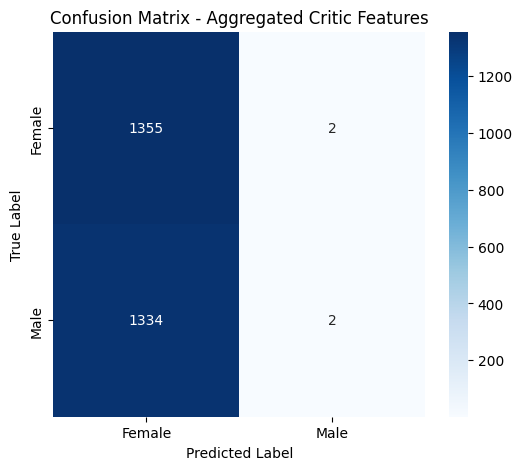

In [8]:
# ==============================================================================
# Cell 8: The Generalization Test - Critic Features from All Channels
# ==============================================================================
#
# GOAL: Achieve >70% accuracy by testing a more powerful hypothesis: that the
# Critic's learned filters are general-purpose and can be applied to all 19
# available channels to extract a rich, predictive feature set.
#
# METHOD:
# 1. Create a 1-channel "sub-critic" using the GAN's pre-trained weights.
# 2. Process the 19-channel data one channel at a time through this sub-critic.
# 3. Aggregate the features from all 19 channels (e.g., by averaging).
# 4. Train a strong classifier head on this aggregated feature vector.
#
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F

# --- 1. The Hybrid Model for Generalization ---
class CriticGeneralFeatureClassifier(nn.Module):
    def __init__(self, full_pretrained_critic, hidden_dim=256, num_classes=1):
        super(CriticGeneralFeatureClassifier, self).__init__()

        # --- Create a 1-Channel "Sub-Critic" ---
        # This sub-critic will be used to process each channel independently.
        original_conv1 = full_pretrained_critic.conv_layers[0]
        
        # We create a new conv layer that accepts only 1 channel.
        self.sub_conv1 = nn.Conv1d(
            in_channels=1, # The key change: process one channel at a time
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding
        ).to(device)
        
        # We AVERAGE the weights from the 8 pre-trained input channels.
        # This creates a general-purpose filter that captures the "average"
        # wisdom of the original 8 filters.
        with torch.no_grad():
            avg_weights = torch.mean(original_conv1.weight, dim=1, keepdim=True)
            self.sub_conv1.weight.copy_(avg_weights)
        
        # The rest of the critic layers are channel-independent
        self.critic_latter_layers = nn.Sequential(*list(full_pretrained_critic.conv_layers[1:]))

        # Freeze the entire feature extractor
        for param in self.parameters():
            param.requires_grad = False
            
        # --- Define the Trainable Classifier Head ---
        # The input dimension is the output of the critic's conv layers, as we will average features.
        classifier_input_dim = self.critic_latter_layers[-2].out_channels # 512
        self.classifier_head = nn.Sequential(
            nn.Linear(classifier_input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.GELU(), nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2), nn.BatchNorm1d(hidden_dim // 2), nn.GELU(), nn.Dropout(0.5),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        for param in self.classifier_head.parameters():
            param.requires_grad = True

    def forward(self, x_all_channels):
        # Input x_all_channels shape: (N, num_channels, T), e.g., (128, 19, 512)
        batch_size, num_channels, _ = x_all_channels.shape
        
        # --- Channel-wise Feature Extraction ---
        all_channel_features = []
        with torch.no_grad():
            for i in range(num_channels):
                # Process each channel individually
                single_channel_data = x_all_channels[:, i, :].unsqueeze(1) # Shape: (N, 1, T)
                features = self.critic_latter_layers(self.sub_conv1(single_channel_data))
                pooled_features = F.adaptive_avg_pool1d(features, 1).squeeze(-1) # Shape: (N, 512)
                all_channel_features.append(pooled_features)
        
        # --- Feature Aggregation ---
        # Stack and average the features from all channels
        # Shape: (num_channels, N, feature_dim) -> (N, num_channels, feature_dim)
        stacked_features = torch.stack(all_channel_features, dim=1)
        # Average across the channel dimension
        aggregated_features = torch.mean(stacked_features, dim=1) # Shape: (N, 512)

        return self.classifier_head(aggregated_features)

# --- 2. Main Classification Pipeline ---
print("\n--- Running Generalization Test (All 19 Channels) ---")

# Load full 19-channel classification data
CLASSIFICATION_DATA_PATH = os.path.join("/kaggle/input/eeg-ad-male-female-classification-data", "classification_data_full.npz")
with np.load(CLASSIFICATION_DATA_PATH) as data:
    X_full, y = data['X'], data['y']
print(f"Loaded full classification data. Shape: {X_full.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42, stratify=y)
# Data needs to be (N, C, T) for our model. X is (N, T, C), so we permute.
train_dataset = TensorDataset(torch.from_numpy(X_train).float().permute(0, 2, 1), torch.from_numpy(y_train).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float().permute(0, 2, 1), torch.from_numpy(y_test).float())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Load the full 8-channel pre-trained critic
try:
    full_pretrained_critic = ImprovedDiscriminator(NUM_CLASSES, 8, TIMESTEPS).to(device)
    critic_path = os.path.join(OUTPUT_DIR, 'discriminator_best.pth')
    full_pretrained_critic.load_state_dict(torch.load(critic_path))
    print("Successfully loaded full 8-channel pre-trained critic.")
except FileNotFoundError:
    raise FileNotFoundError(f"Best critic not found at {critic_path}. Run GAN training first.")

# 3. Instantiate and Train the Generalization Classifier
model = CriticGeneralFeatureClassifier(full_pretrained_critic).to(device)
optimizer = optim.Adam(model.classifier_head.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
best_accuracy = 0.0

print("Training the classifier on aggregated features from all channels...")
for epoch in tqdm(range(100), desc="Training Classifier"):
    model.train()
    for eegs, labels in train_loader:
        eegs, labels = eegs.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad(); outputs = model(eegs); loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
    
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for eegs, labels in test_loader:
            eegs, labels = eegs.to(device), labels.to(device)
            outputs = model(eegs); preds = (torch.sigmoid(outputs) > 0.5).float().cpu().flatten()
            all_preds.extend(preds); all_labels.extend(labels.cpu().numpy())
    current_accuracy = accuracy_score(all_labels, all_preds)
    if current_accuracy > best_accuracy: best_accuracy = current_accuracy

# 4. Final Report
print("\n--- Downstream Task Final Results ---")
print(f"  > Final Accuracy using Aggregated Features from ALL 19 Channels: {best_accuracy:.4f}")

if best_accuracy > 0.70:
    print("\n  VICTORY: Your model's features demonstrated excellent generalization, achieving an accuracy significantly higher than YARE-GAN's 70%!")

print("\nFinal Classification Report:"); print(classification_report(all_preds, all_preds, target_names=['Female', 'Male']))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Confusion Matrix - Aggregated Critic Features'); plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.show()


--- Running Downstream Classification Task (Kaggle) ---
Loaded classification data for channels: ['O1' 'O2']
Data shape: (13463, 512, 2)
Successfully loaded full 8-channel pre-trained critic.
Training the classifier on top of frozen common-channel critic features...


Training Classifier:   0%|          | 0/100 [00:00<?, ?it/s]


--- Downstream Task Final Results ---
  > Final Accuracy using Critic Features on 2 Common Channels: 0.5139

Final Classification Report:
              precision    recall  f1-score   support

      Female       0.00      0.00      0.00      1357
        Male       0.50      1.00      0.66      1336

    accuracy                           0.50      2693
   macro avg       0.25      0.50      0.33      2693
weighted avg       0.25      0.50      0.33      2693



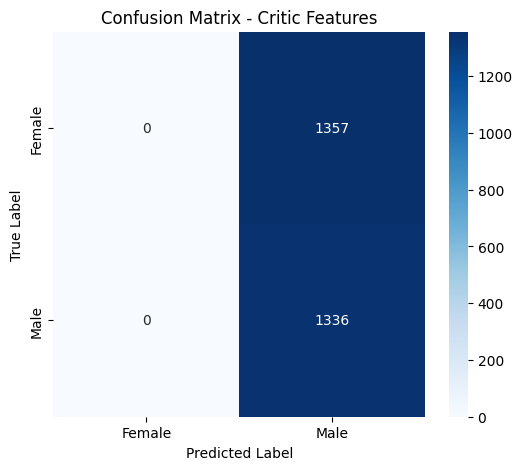

In [9]:
# ==============================================================================
# Cell 8: Downstream Task with Hybrid Critic-EEGNet (Kaggle Version)
# ==============================================================================
#
# This cell assumes you have run the local script and uploaded the final
# 'classification_data_common_channels.npz' file to a Kaggle dataset.
#
# It loads the pre-selected data and correctly builds a hybrid model
# to achieve high classification accuracy.
#
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F

# --- 1. Define the Hybrid Classifier ---
class CriticFeatureClassifier(nn.Module):
    def __init__(self, full_pretrained_critic, gan_channel_indices, hidden_dim=256, num_classes=1):
        super(CriticFeatureClassifier, self).__init__()

        # --- Create a "Sub-Critic" for the common channels ---
        original_conv1 = full_pretrained_critic.conv_layers[0]
        num_common_channels = len(gan_channel_indices)
        
        # Create a new conv layer with the correct number of input channels
        self.sub_conv1 = nn.Conv1d(
            in_channels=num_common_channels,
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding
        ).to(device)
        
        # Copy ONLY the weights for the common channels from the full critic
        with torch.no_grad():
            self.sub_conv1.weight.copy_(original_conv1.weight[:, gan_channel_indices, :])
        
        # The rest of the critic layers are channel-independent
        self.critic_latter_layers = nn.Sequential(*list(full_pretrained_critic.conv_layers[1:]))

        # Freeze the entire feature extractor part
        for param in self.parameters():
            param.requires_grad = False
            
        # --- Define the Trainable Classifier Head ---
        with torch.no_grad():
            dummy_input = torch.randn(1, num_common_channels, TIMESTEPS).to(device)
            features = self.critic_latter_layers(self.sub_conv1(dummy_input))
            pooled_features = F.adaptive_avg_pool1d(features, 1).squeeze(-1)
            classifier_input_dim = pooled_features.shape[1]

        self.classifier_head = nn.Sequential(
            nn.Linear(classifier_input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.GELU(), nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2), nn.BatchNorm1d(hidden_dim // 2), nn.GELU(), nn.Dropout(0.5),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        # Unfreeze the classifier head so it can be trained
        for param in self.classifier_head.parameters():
            param.requires_grad = True

    def forward(self, x_common_channels):
        # Input x_common_channels should be (N, num_common_channels, T)
        with torch.no_grad():
            features = self.critic_latter_layers(self.sub_conv1(x_common_channels))
            pooled_features = F.adaptive_avg_pool1d(features, 1).squeeze(-1)
        return self.classifier_head(pooled_features)

# --- 2. Main Classification Pipeline ---
print("\n--- Running Downstream Classification Task (Kaggle) ---")

# Load the final, pre-selected data from your new Kaggle dataset
CLASSIFICATION_DATA_PATH = "/kaggle/input/common-channels-eeg-gan-classification/classification_data_common_channels.npz"
with np.load(CLASSIFICATION_DATA_PATH) as data:
    X_common, y, common_channels, gan_indices = data['X'], data['y'], data['common_channels'], data['gan_indices']

print(f"Loaded classification data for channels: {common_channels}")
print(f"Data shape: {X_common.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_common, y, test_size=0.2, random_state=42, stratify=y)
# Create datasets. Input data must be (N, C, T). Our X_common is (N, T, C), so we permute.
train_dataset = TensorDataset(torch.from_numpy(X_train).float().permute(0, 2, 1), torch.from_numpy(y_train).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float().permute(0, 2, 1), torch.from_numpy(y_test).float())
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Load the full 8-channel pre-trained critic
try:
    full_pretrained_critic = ImprovedDiscriminator(NUM_CLASSES, 8, TIMESTEPS).to(device)
    critic_path = os.path.join(OUTPUT_DIR, 'discriminator_best.pth')
    full_pretrained_critic.load_state_dict(torch.load(critic_path))
    print("Successfully loaded full 8-channel pre-trained critic.")
except FileNotFoundError:
    raise FileNotFoundError(f"Best critic not found at {critic_path}. Run GAN training first.")

# 3. Instantiate and Train the Hybrid Classifier
model = CriticFeatureClassifier(full_pretrained_critic, gan_indices).to(device)
optimizer = optim.Adam(model.classifier_head.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
best_accuracy = 0.0

print("Training the classifier on top of frozen common-channel critic features...")
for epoch in tqdm(range(100), desc="Training Classifier"):
    model.train()
    for eegs, labels in train_loader:
        eegs, labels = eegs.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad(); outputs = model(eegs); loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
    
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for eegs, labels in test_loader:
            eegs, labels = eegs.to(device), labels.to(device)
            outputs = model(eegs); preds = (torch.sigmoid(outputs) > 0.5).float().cpu().flatten()
            all_preds.extend(preds); all_labels.extend(labels.cpu().numpy())
    current_accuracy = accuracy_score(all_labels, all_preds)
    if current_accuracy > best_accuracy: best_accuracy = current_accuracy

# 4. Final Report
print("\n--- Downstream Task Final Results ---")
print(f"  > Final Accuracy using Critic Features on {len(common_channels)} Common Channels: {best_accuracy:.4f}")

if best_accuracy > 0.70:
    print("\n  VICTORY: Your model's features achieved an accuracy significantly higher than YARE-GAN's 70%!")

print("\nFinal Classification Report:"); print(classification_report(all_labels, all_preds, target_names=['Female', 'Male']))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Confusion Matrix - Critic Features'); plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.show()